## Flux through shelf-break wall module - function design

In this notebook a "wall" along the shelf break is defined and the flux through it is calculated. The wall goes from shelf-break depth all the way to the surface and goes around the canyon.

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [5]:
#CanyonGrid='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/gridGlob.nc'
#CanyonGridOut = Dataset(CanyonGrid)

CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

#CanyonState='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/stateGlob.nc'
CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/stateGlob.nc'

CanyonStateOut = Dataset(CanyonState)

FluxTH = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxTHGlob.nc'
FluxSLT = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxSLTGlob.nc'
FluxTR01 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxTR01Glob.nc'
FluxTR02 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxTR02Glob.nc'
FluxOut = Dataset(FluxTR02)


In [8]:
# General input

nx = 360
ny = 360
nz = 90

nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
#print(z[10])
Time = CanyonStateOut.variables['T']
#print(Time[:])

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacW = rout.getField(CanyonGrid, 'HFacW') # (Z,Y,Xp1) for zonal fluxes
MaskW = rout.getMask(CanyonGrid,'HFacW') 

hFacS = rout.getField(CanyonGrid, 'HFacS') # (Z,Yp1,X) for meridional fluxes
MaskS = rout.getMask(CanyonGrid,'HFacS') 


In [9]:
sns.set()
sns.set_style('white')
sns.set_context('notebook')

The shelf-break isobath (sb=315.36 m) upstream of the canyon corresponds to the y-index 198
The corresponding index for z is   (z(29)=147.50 m)


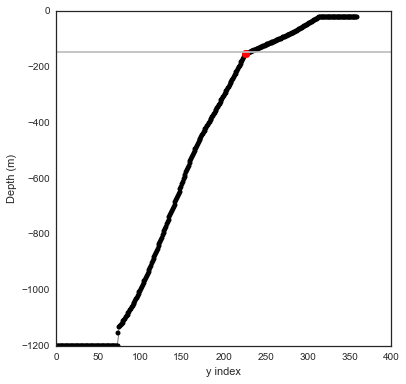

In [20]:
fig = plt.figure(figsize=(6,6))

CS = plt.plot(range(360),-bathy[:,120],'ko-',markersize=5,linewidth=0.5)
plt.plot(226,-bathy[226,120],'ro',markersize=8)
plt.axhline(y=z[29],xmin=0,xmax=360,linestyle='-', color='0.75')

plt.ylabel('Depth (m)')
plt.xlabel('y index')
print('The shelf-break isobath (sb=%.2f m) upstream of the canyon corresponds to the y-index 198' % bathy[198,120])
print('The corresponding index for z is   (z(29)=%.2f m)' % -z[29])

In [7]:
ix,iy = np.where((bathy>=146.8) & (bathy<=148.7))
print(np.shape(ix))


(324,)


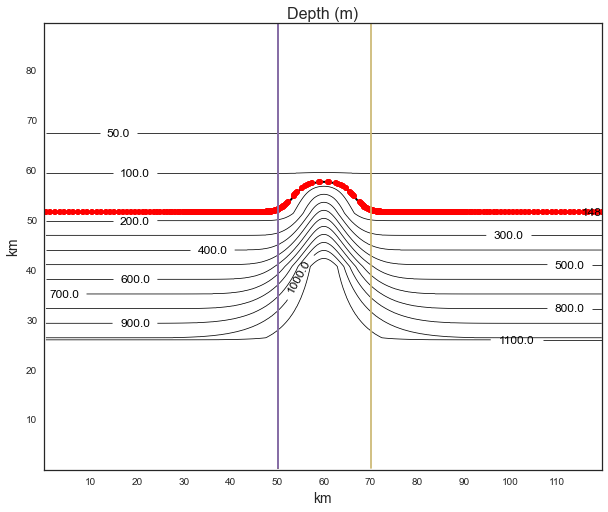

In [140]:
fig = plt.figure(figsize=(10,8))

lev = range(200,1200,100)

levels = [50,100,148.17]+lev
CS = plt.contour(xc,yc,bathy,levels,colors='k',linewidths=[0.75,0.75,2,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75] )

plt.clabel(CS, 
           inline=1,
          fmt='%1.1f',
           fontsize=12)

plt.plot(xc[ix,iy],yc[ix,iy], 'ro',markersize=6)
plt.plot(xc[:,130],yc[:,:130] )
plt.plot(xc[:,-130],yc[:,-130] )

plt.xticks(np.arange(0,120000,10000), [' ','10','20','30','40','50','60','70','80','90','100','110','120'])
plt.yticks(np.arange(0,90000,10000), [' ','10','20','30','40','50','60','70','80','90'])

plt.xlabel('km',fontsize=14)
plt.ylabel('km',fontsize=14)

plt.title('Depth (m)',fontsize=16)


In [ ]:
# THIS FUNCTION WAS ADDED TO module ShelfBreakTools_MITgcm.py

def findShelfBreak(zlev,hfac):
    '''Find the x and y indices of the shelf break cells at a given vertical level. 
    This function looks for the first element of hfac[zlev,:,kk] (all the elements of 
    hfac at a certain zlevel and alongshore position) that is completely closed (hfac=0) 
    and saves its x,y indices in the integer arrays SBx, SBy.
    -----------------------------------------------------------------------------------
    INPUT
         
    zlev : vertical level to find shelf break indices
    hfac : open-cell fraction array. It should be the cell-centered HFacC.
     
    OUTPUT
    
    SBx, SBy : two integer arrays containing the x and y indices (respectively) of the shelf break. 
    '''
    
    sizes = np.shape(hfac)
    nx = sizes[2]
    ny = sizes[1]
    
      
    SBIndx = np.empty(nx)
    SBIndy = np.empty(nx)

    for kk in range(nx):
        SBIndy[kk] = np.argmax(hfac[zlev,:,kk]==0)
        SBIndx[kk] = kk

    SBx = SBIndx.astype(int)
    SBy = SBIndy.astype(int)
    
    return(SBx,SBy)

#print(SBy) 
#print(hFacC[29,SBIndy[30],SBIndx[30]])

In [81]:
# THIS FUNCTION WAS ADDED TO module ShelfBreakTools_MITgcm.py

def AreaWallSB(hfac,dr,dx,zlev):
    '''Calculate area of Shelf break wall.
    -----------------------------------------------------------------------------------
    INPUT
    hfac : Fraction of open cell at cell center (hFacC)     
    dr : r cell face separation (drf)
    dx : x cell center separation (dxf)
    zlev : vertical level to find shelf break indices
    
    NOTE - This function uses findShelfBreak(zlev,hfac) to get the x, y indices of shelf break.
    
    OUTPUT
    area : np 2D array size x,z 
    '''
    
    SBxx, SByy = findShelfBreak(zlev,hfac)

    sizes = np.shape(hfac)
    nx = sizes[2]
    ny = sizes[1]
    nz = sizes[0]
    
    area = np.empty((nz,nx))
    
    for ii in range(nx):
        area[:,ii] = hfac[:,SByy[ii],SBxx[ii]] * dr[:] * dx[SByy[ii],SBxx[ii]]
        

    
    return(area)
    


In [136]:
SBxx,SByy = findShelfBreak(29,hFacC)

print(SByy[133], SBxx[133])

(204, 133)


The red dots represent the cells that were defined as the shelf break by the algorithm


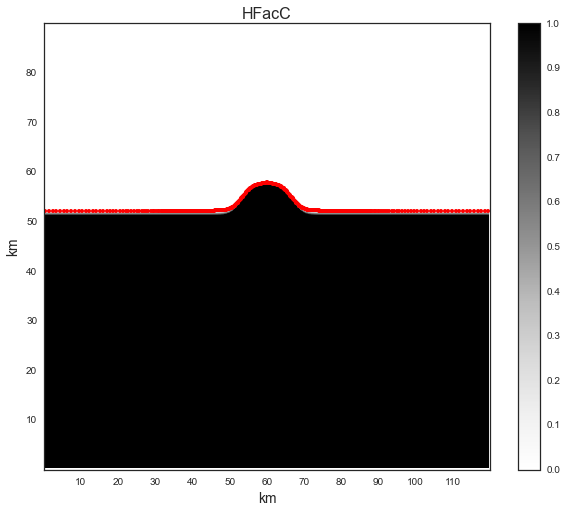

In [11]:
fig = plt.figure(figsize=(10,8))

CS = plt.pcolor(xc,yc,hFacC[29,:,:])


plt.plot(xc[SByy,SBxx],yc[SByy,SBxx], 'ro',markersize=4)
plt.colorbar()

plt.xticks(np.arange(0,120000,10000), [' ','10','20','30','40','50','60','70','80','90','100','110','120'])
plt.yticks(np.arange(0,90000,10000), [' ','10','20','30','40','50','60','70','80','90'])

plt.xlabel('km',fontsize=14)
plt.ylabel('km',fontsize=14)

plt.title('HFacC',fontsize=16)

print('The red dots represent the cells that were defined as the shelf break by the algorithm')

Based on the indices of the shelf break a 'wall' around the shelf can be defined from shelf to surface. Fluxes across this wall are calculated in the following.

In [12]:
#Vertical Fluxes
#ADVrTH = rout.getField(FluxTH,'ADVr_TH') # Vertical advective transport THETA
#ADVrSLT = rout.getField(FluxSLT,'ADVr_SLT') # Vertical advective transport 
ADVyTR01 = rout.getField(FluxTR01,'ADVyTr01') # Vertical advective transport 

#ADVrTR02 = rout.getField(FluxTR02,'ADVrTr02') # Vertical advective transport 
DFyETR01 = rout.getField(FluxTR01,'DFyETr01') # Vertical diff flux implicit


In [104]:
# THIS FUNCTION WAS ADDED TO module ShelfBreakTools_MITgcm.py

def FluxSB(time,Flux,z,x,zlev,hfac,Mask):
    '''Flux across shelf break - This function uses fingShelfBreak to get the indices of the cells along the shelf break 
    (with or without canyon) and returns a (nz,nx) array with the flux across those cells from bottom to surface. The flux 
    should be normal to the shelf break, so only the meridional component of flux is used. This function can also work 
    for transport.
     -------------------------------------------------------------------------------------------------------------------
     INPUT: time -  time output 
            Flux - array with meridional flux data from MITgcm model. The shape should be (nt,nz,ny,nx)
            z - 1D array with z-level depth data
            x - alongshore coordinates (2D)
            hfac - open cell fraction that works as mask
            zlev - vertical level at which to get the shelf break indices
    OUTPUT : array [nz,nx] with flux values across shelfbreak
    ----------------------------------------------------------------------------------------------------------------------
    '''
    SBxx, SByy = findShelfBreak(zlev,hfac)

    sizes = np.shape(hfac)
    nx = sizes[2]
    ny = sizes[1]
    nz = sizes[0]
    
    FluxY = np.empty((nz,nx))
    MaskY = np.empty((nz,nx))

    unstagFlux = np.add(Flux[..., :-1, :], Flux[..., 1:, :]) / 2
        
    for ii in range(nx):
        FluxY[:,ii] = unstagFlux[time,:,SByy[ii],SBxx[ii]] 
        MaskY[:,ii] = Mask[:,SByy[ii],SBxx[ii]]

    FluxYmask = np.ma.array(FluxY,mask=MaskY)
    return(FluxYmask)

In [146]:
# THIS FUNCTION WAS ADDED TO module ShelfBreakTools_MITgcm.py

def contourfFluxSB(time,numCols,numRows,FluxPlot,z,x,units, nzmin,nzmax,kk,zlev):
    ''' Contourf plot of flux across shelf break wall' 
     -------------------------------------------------------------------------------------------------------------------
     INPUT:  time - timeslice at what we want to plot (integer, usually between 0 and 18)
            numCols, numRows - integers indicating, respectively, the number of columns and rows to arrange the subplots into.
             Flux - array with across shelf break flux data (nz,nx)
                z - 1D array with z-level depth data
                x - alongshore coordinates (2D)
            nzmin - integer indicating index of lower depth (z) to plot. Remember z goes form 0 to -2000 m. 
            nzmax - integer indicating index of upper depth (z) to plot. Remember z goes form 0 to -2000 m. 
            units - string with units for colorbar. E.g. units = '$molC\ m^{-1}\cdot m^3s^{-1}$' 
               kk - Integer inidcating the number of subplot 
             zlev - vertical level at which to get the shelf break indices
    OUTPUT : Nice contourf subplot
    ----------------------------------------------------------------------------------------------------------------------
    '''
    
    plt.subplot(numRows,numCols,kk)
    ax = plt.gca()

    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    plt.contourf(x[200,:],z[nzmin:nzmax],FluxPlot[nzmin:nzmax,:],cmap = "RdYlBu_r")

    if abs(np.max(FluxPlot)) >= abs(np.min(FluxPlot)):
        pl.clim([-np.max(FluxPlot),np.max(FluxPlot)])
    else:
        pl.clim([np.min(FluxPlot),-np.min(FluxPlot)])
    
    plt.axvline(x=x[0,130],linestyle='-', color='0.75')
    plt.axvline(x=x[0,-130],linestyle='-', color='0.75')
    
    plt.xlabel('m')
        
    plt.ylabel('m')

    cb = plt.colorbar()

    cb.set_label(units,position=(1, 0),rotation=0)

    plt.title(" %1.1f days " % ((tt/2.)+0.5))

    


In [148]:
# THIS FUNCTION WAS ADDED TO module ShelfBreakTools_MITgcm.py



def pcolorFluxSB(time,numCols,numRows,FluxPlot,z,x,units, nzmin,nzmax,kk,zlev):
    ''' pcolor plot of flux across shelf break wall' 
     -------------------------------------------------------------------------------------------------------------------
    INPUT:  time - timeslice at what we want to plot (integer, usually between 0 and 18)
            numCols, numRows - integers indicating, respectively, the number of columns and rows to arrange the subplots into.
             Flux - array with across shelf break flux data (nz,nx)
                z - 1D array with z-level depth data
                x - alongshore coordinates (2D)
            nzmin - integer indicating index of lower depth (z) to plot. Remember z goes form 0 to -2000 m. 
            nzmax - integer indicating index of upper depth (z) to plot. Remember z goes form 0 to -2000 m. 
            units - string with units for colorbar. E.g. units = '$molC\ m^{-1}\cdot m^3s^{-1}$' 
               kk - Integer inidcating the number of subplot 
             zlev - vertical level at which to get the shelf break indices
    OUTPUT : Nice pcolor subplot
    ----------------------------------------------------------------------------------------------------------------------
    '''
    plt.subplot(numRows,numCols,kk)
    ax = plt.gca()

    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    plt.pcolor(x[200,:],z[nzmin:nzmax],FluxPlot[nzmin:nzmax,:],cmap = "RdYlBu_r")

    if abs(np.max(FluxPlot)) >= abs(np.min(FluxPlot)):
        pl.clim([-np.max(FluxPlot),np.max(FluxPlot)])
    else:
        pl.clim([np.min(FluxPlot),-np.min(FluxPlot)])
    
    plt.axvline(x=x[0,130],linestyle='-', color='0.75')
    plt.axvline(x=x[0,-130],linestyle='-', color='0.75')
    
    plt.xlabel('m')
        
    plt.ylabel('m')

    cb = plt.colorbar()

    cb.set_label(units,position=(1, 0),rotation=0)

    plt.title(" %1.1f days " % ((tt/2.)+0.5))

    


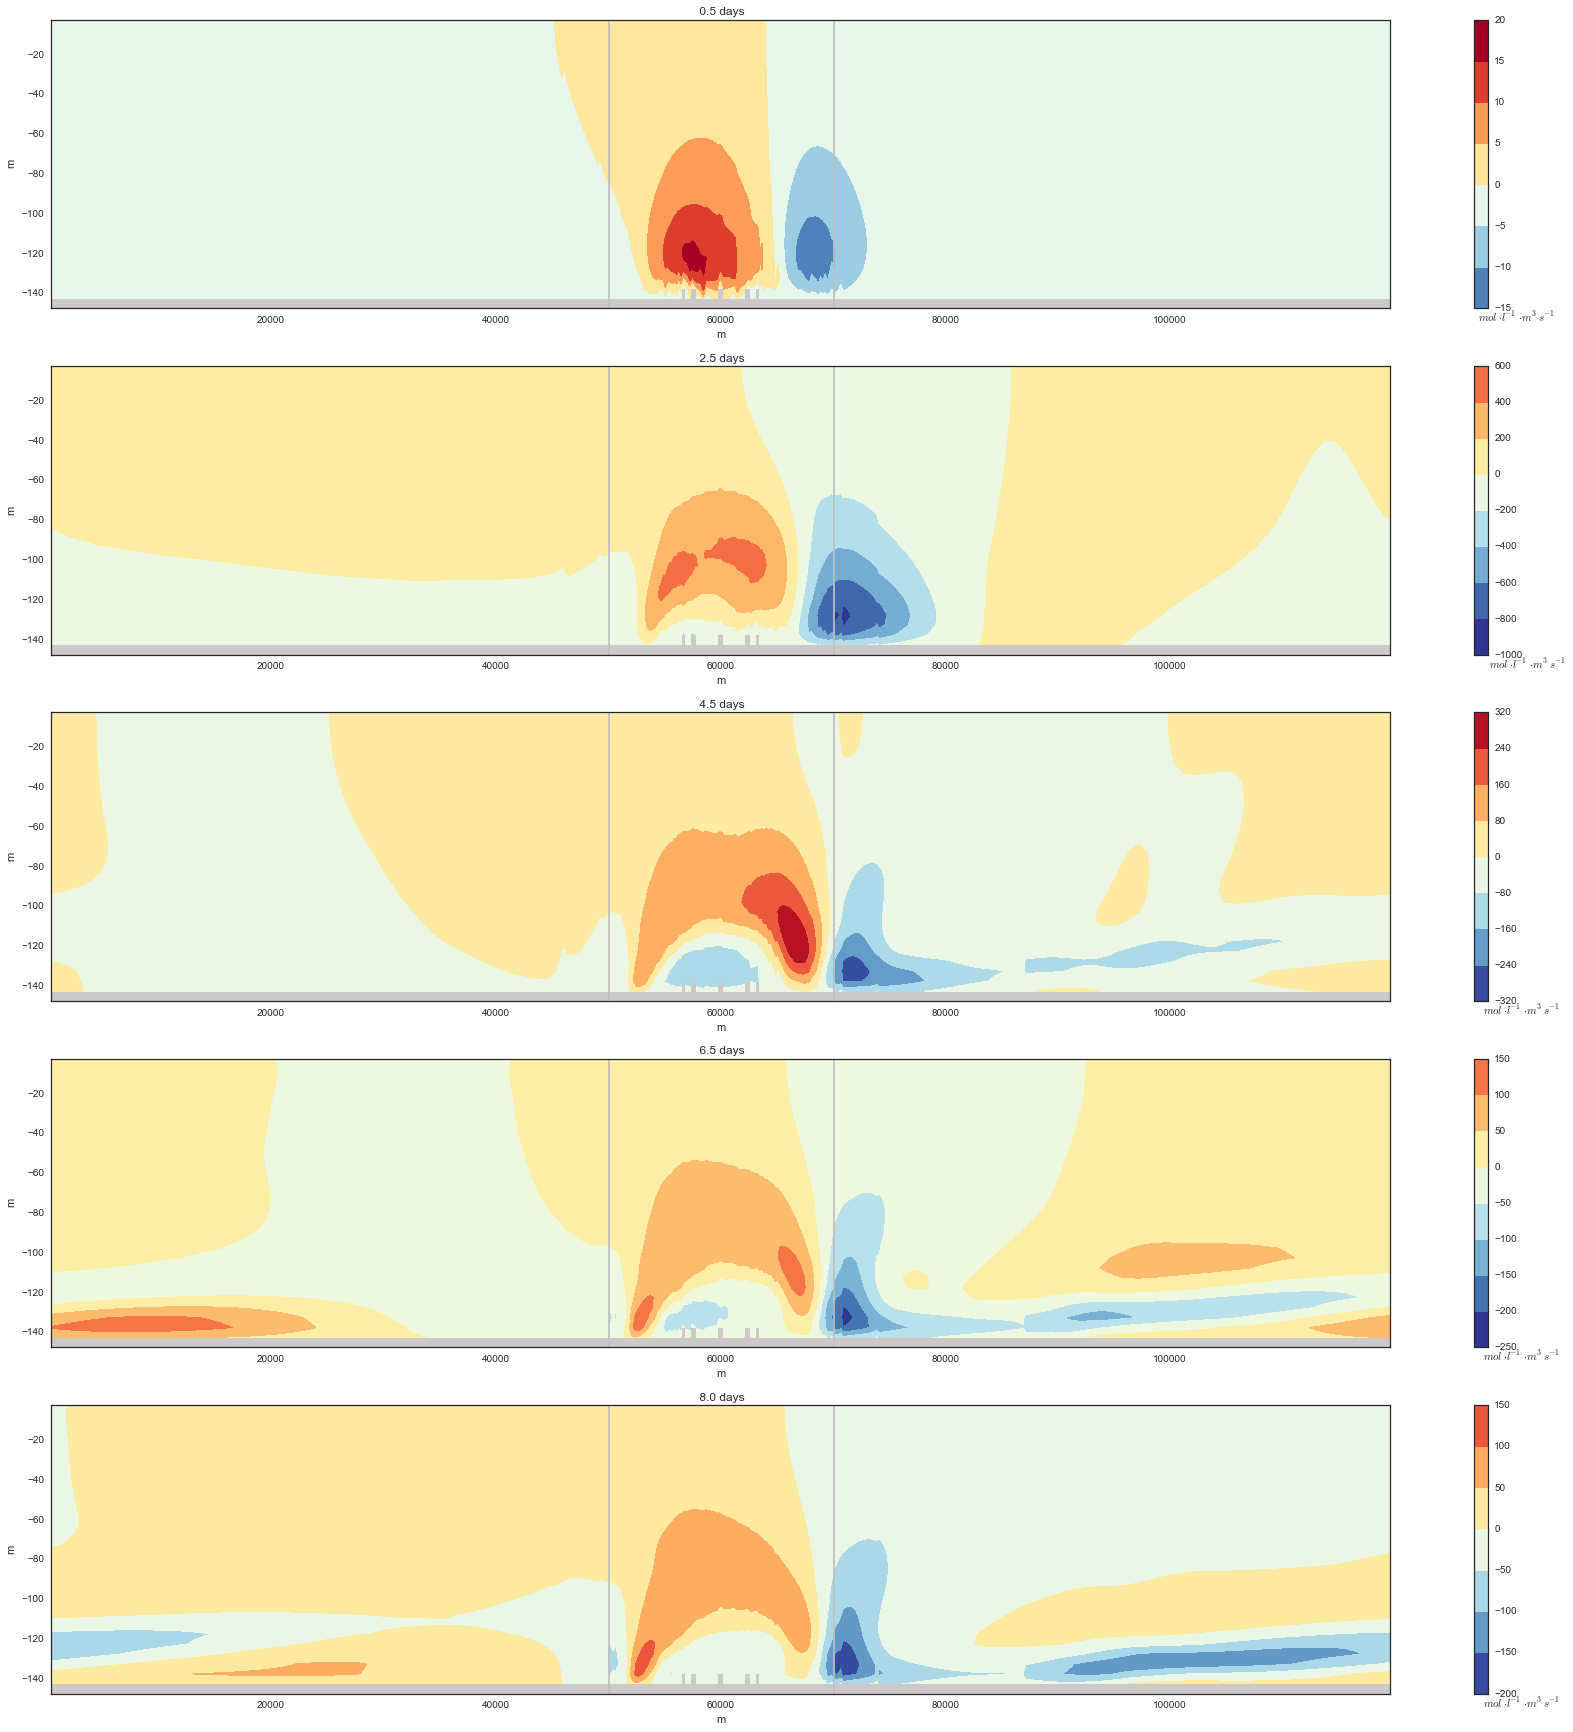

In [147]:
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 

figSize=(30,30)
numCols = 1
numRows = 5
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'
kk=1

fig44 = plt.figure(figsize=figSize)

for tt in times:
    AdvFluxPlot = FluxSB(tt,ADVyTR01,z,xc,zlev,hFacC,MaskC)
    AdvFluxPlotNoC = FluxSB(tt,ADVyTr01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    contourfFluxSB(tt,numCols,numRows,AdvFluxPlot-AdvFluxPlotNoC,z,xc,unitsTr, 0,30,kk,zlev)
    
    
    kk = kk+1

    
    
    
    #pcolorFluxSB(times,figSize,numCols,numRows,ADVyTR01,z,xc,unitsTr,zlev,hFacC,MaskC )

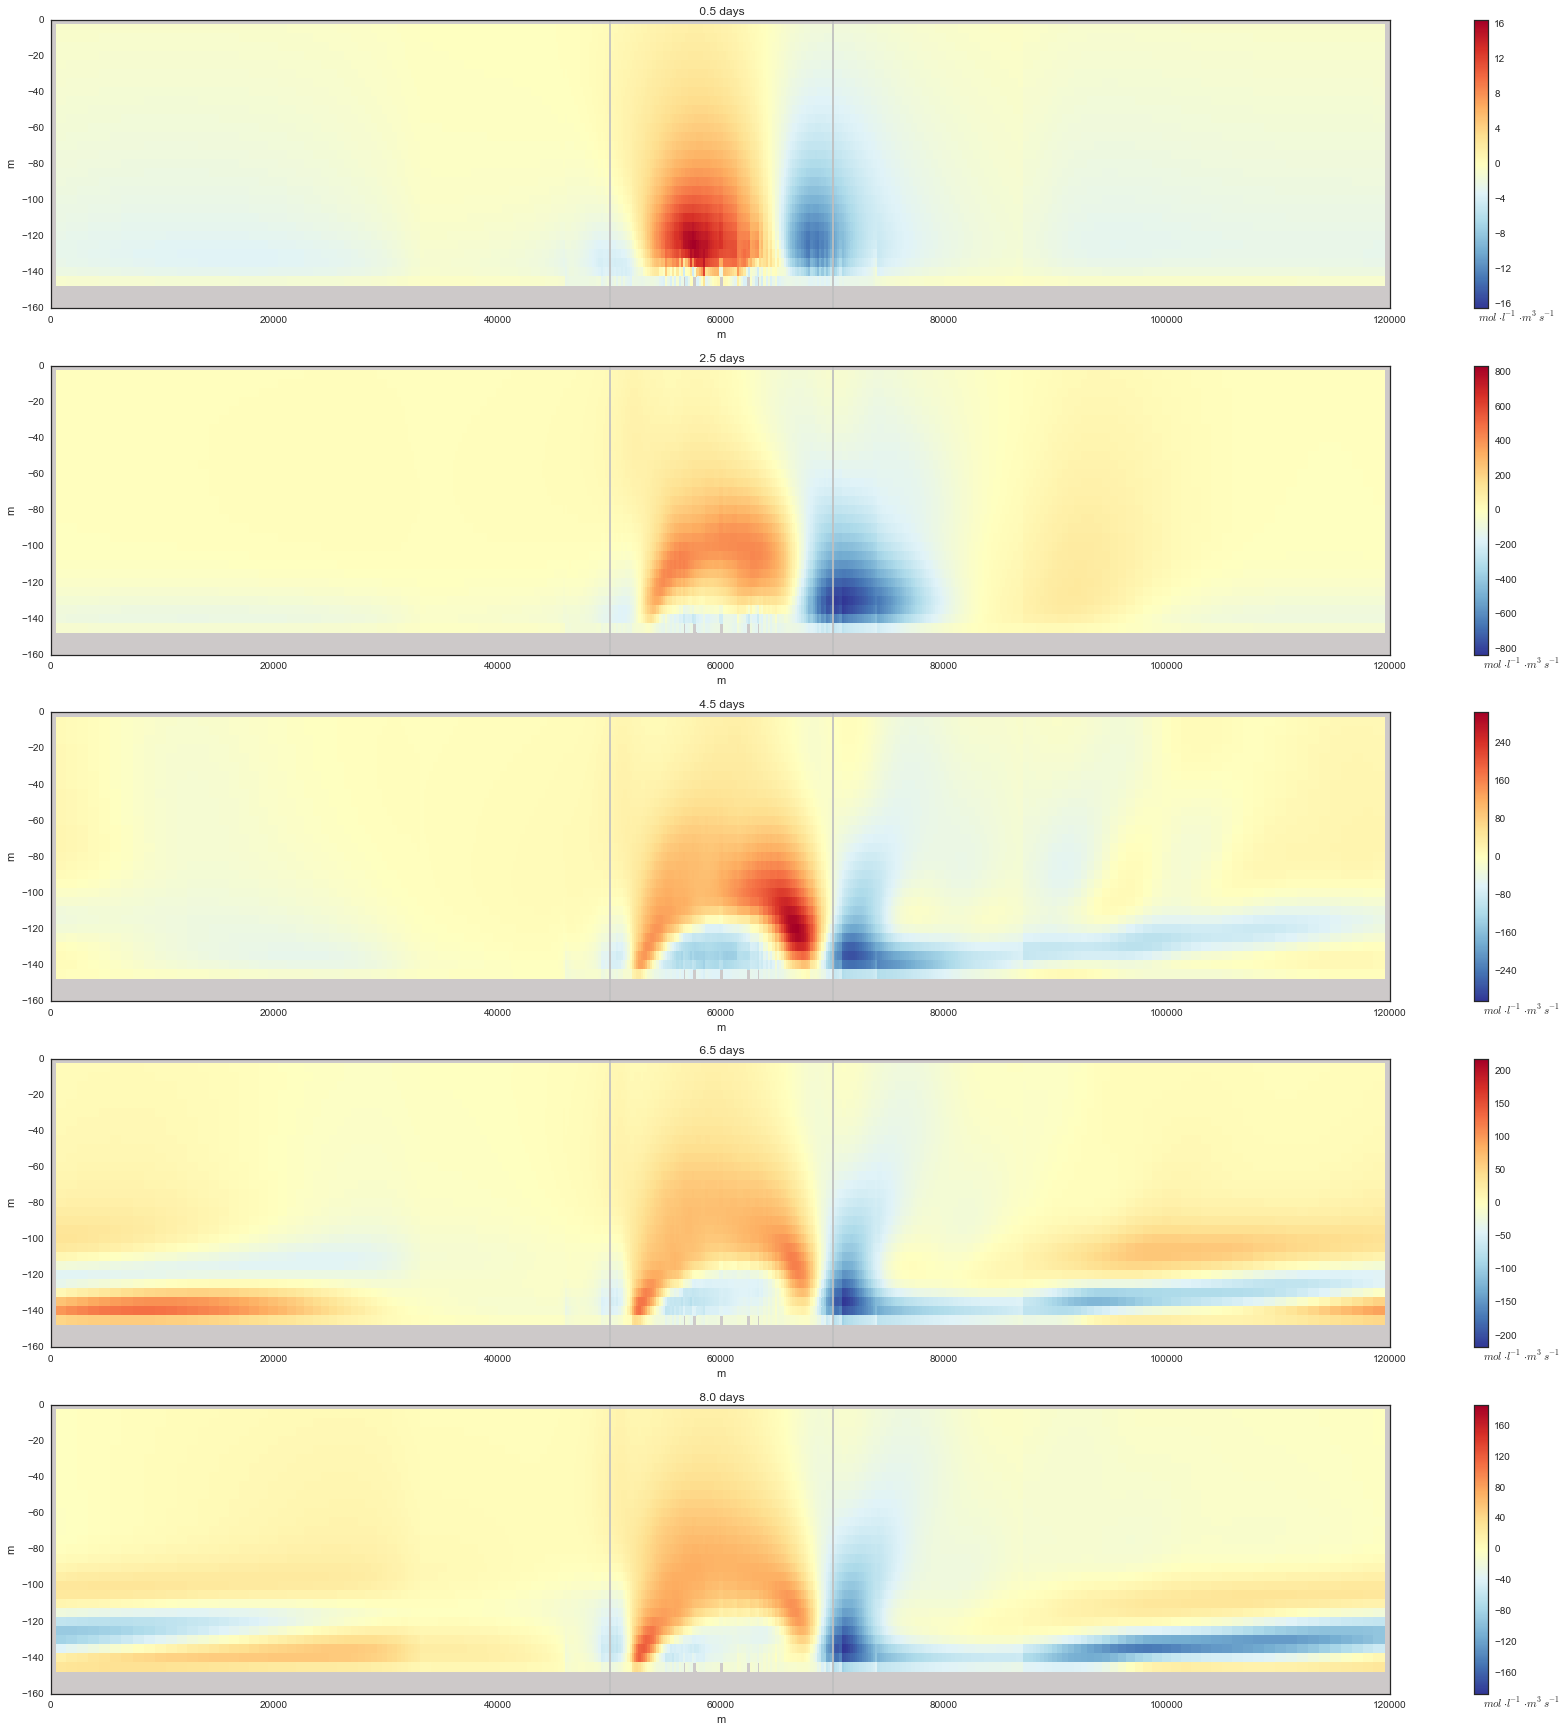

In [149]:
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 

figSize=(30,30)
numCols = 1
numRows = 5
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'
kk=1

fig44 = plt.figure(figsize=figSize)

for tt in times:
    AdvFluxPlot = FluxSB(tt,ADVyTR01,z,xc,zlev,hFacC,MaskC)
    AdvFluxPlotNoC = FluxSB(tt,ADVyTr01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    pcolorFluxSB(tt,numCols,numRows,AdvFluxPlot-AdvFluxPlotNoC,z,xc,unitsTr, 0,30,kk,zlev)
    
    
    kk = kk+1

    
    
    
    #pcolorFluxSB(times,figSize,numCols,numRows,ADVyTR01,z,xc,unitsTr,zlev,hFacC,MaskC )

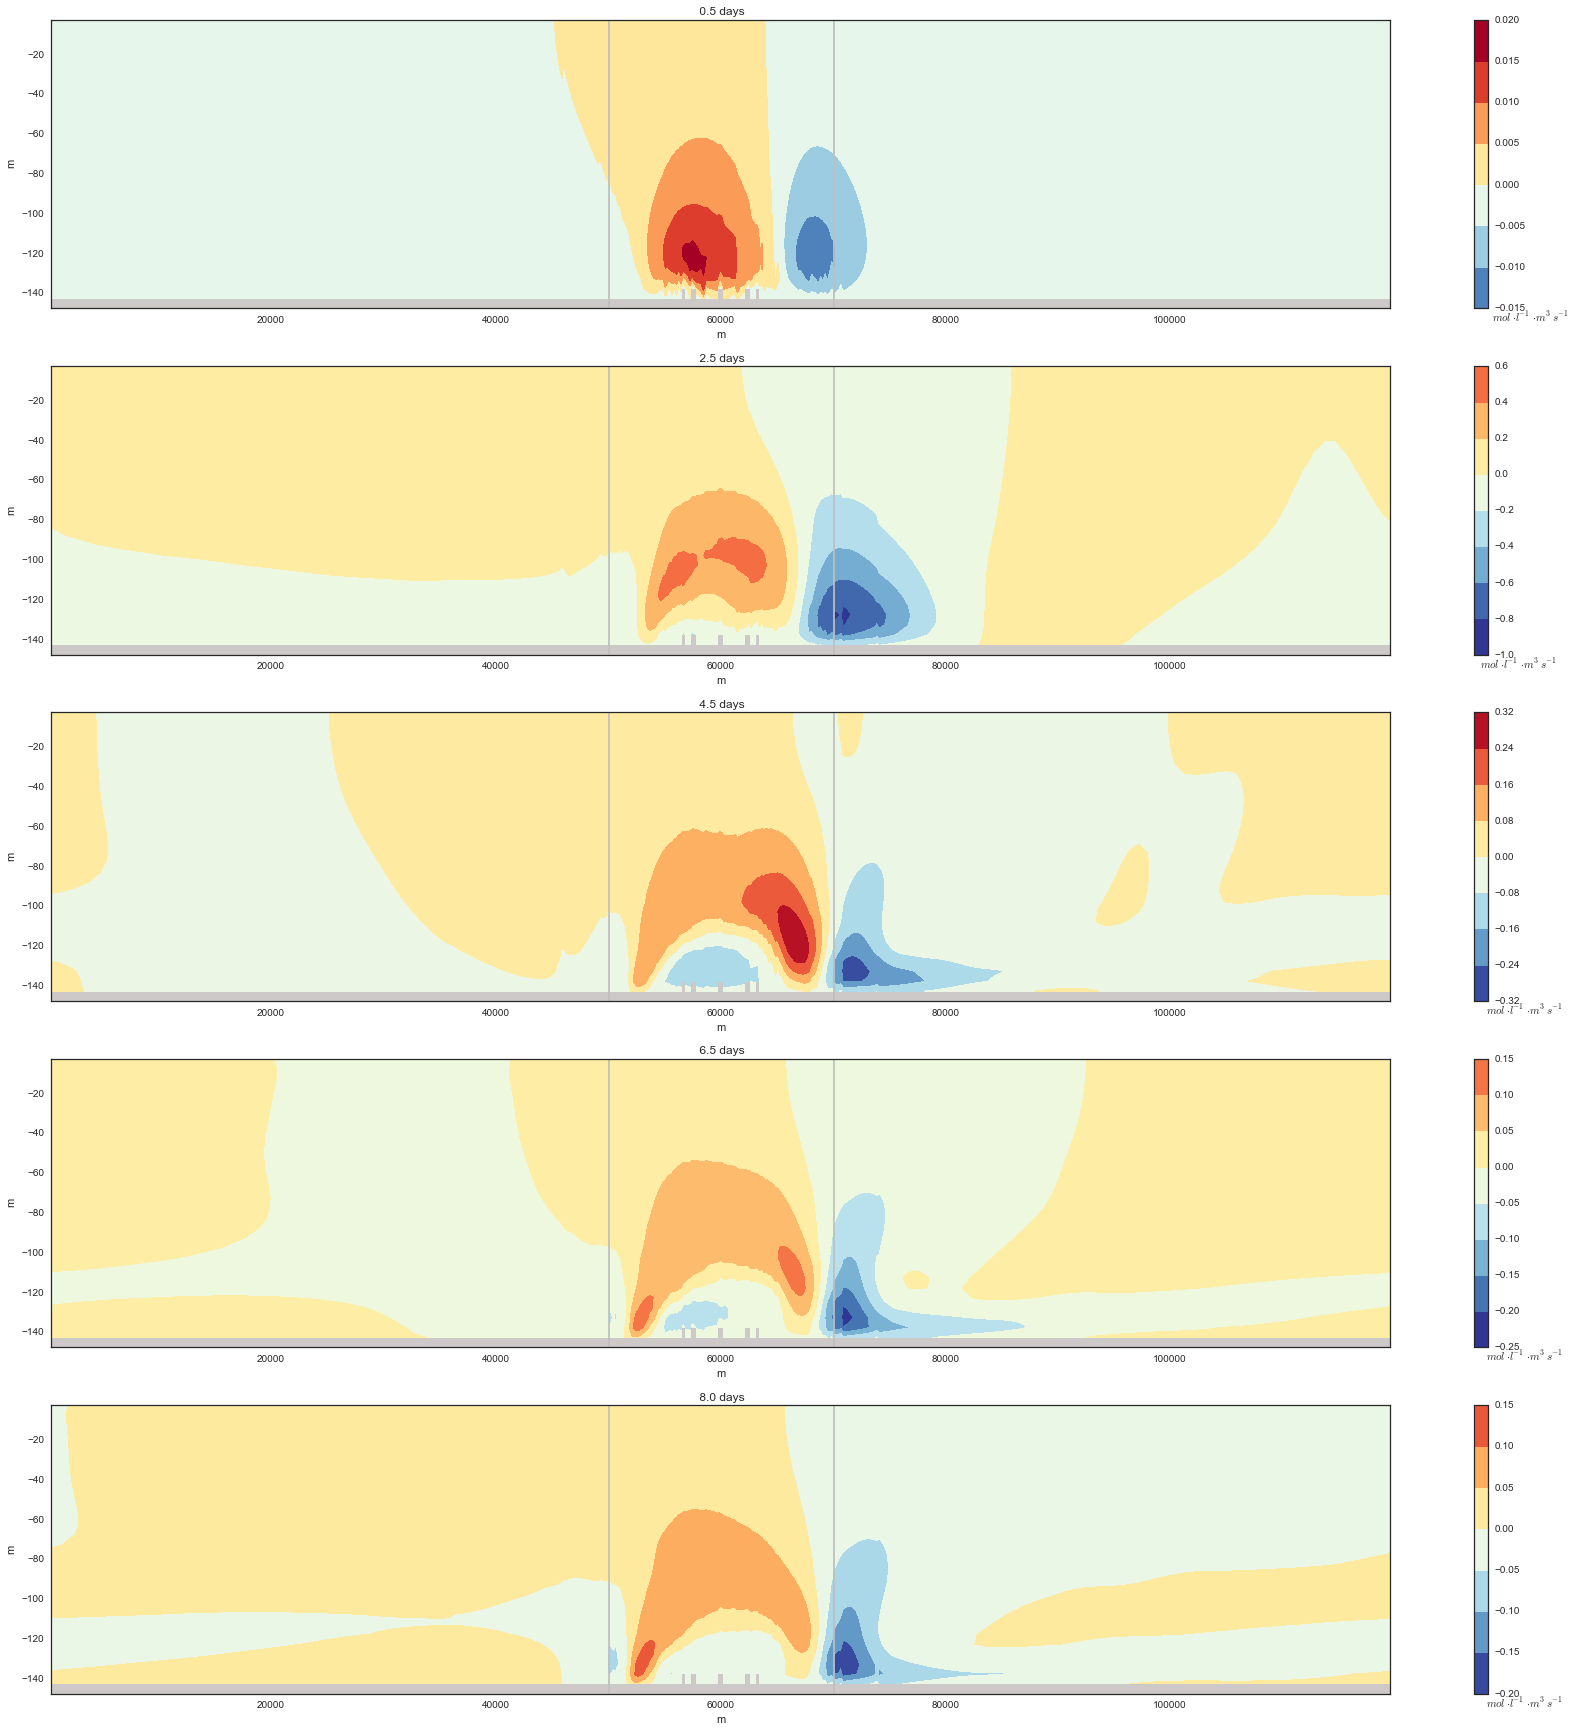

In [150]:
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 

figSize=(30,30)
numCols = 1
numRows = 5
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'
kk=1

fig44 = plt.figure(figsize=figSize)

for tt in times:
    VTRACPlot = FluxSB(tt,VTRAC01,z,xc,zlev,hFacC,MaskC)
    VTRACPlotNoC = FluxSB(tt,VTRAC01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    contourfFluxSB(tt,numCols,numRows,VTRACPlot-VTRACPlotNoC,z,xc,unitsTr, 0,30,kk,zlev)
    
    
    kk = kk+1

    
    
    
    #pcolorFluxSB(times,figSize,numCols,numRows,ADVyTR01,z,xc,unitsTr,zlev,hFacC,MaskC )

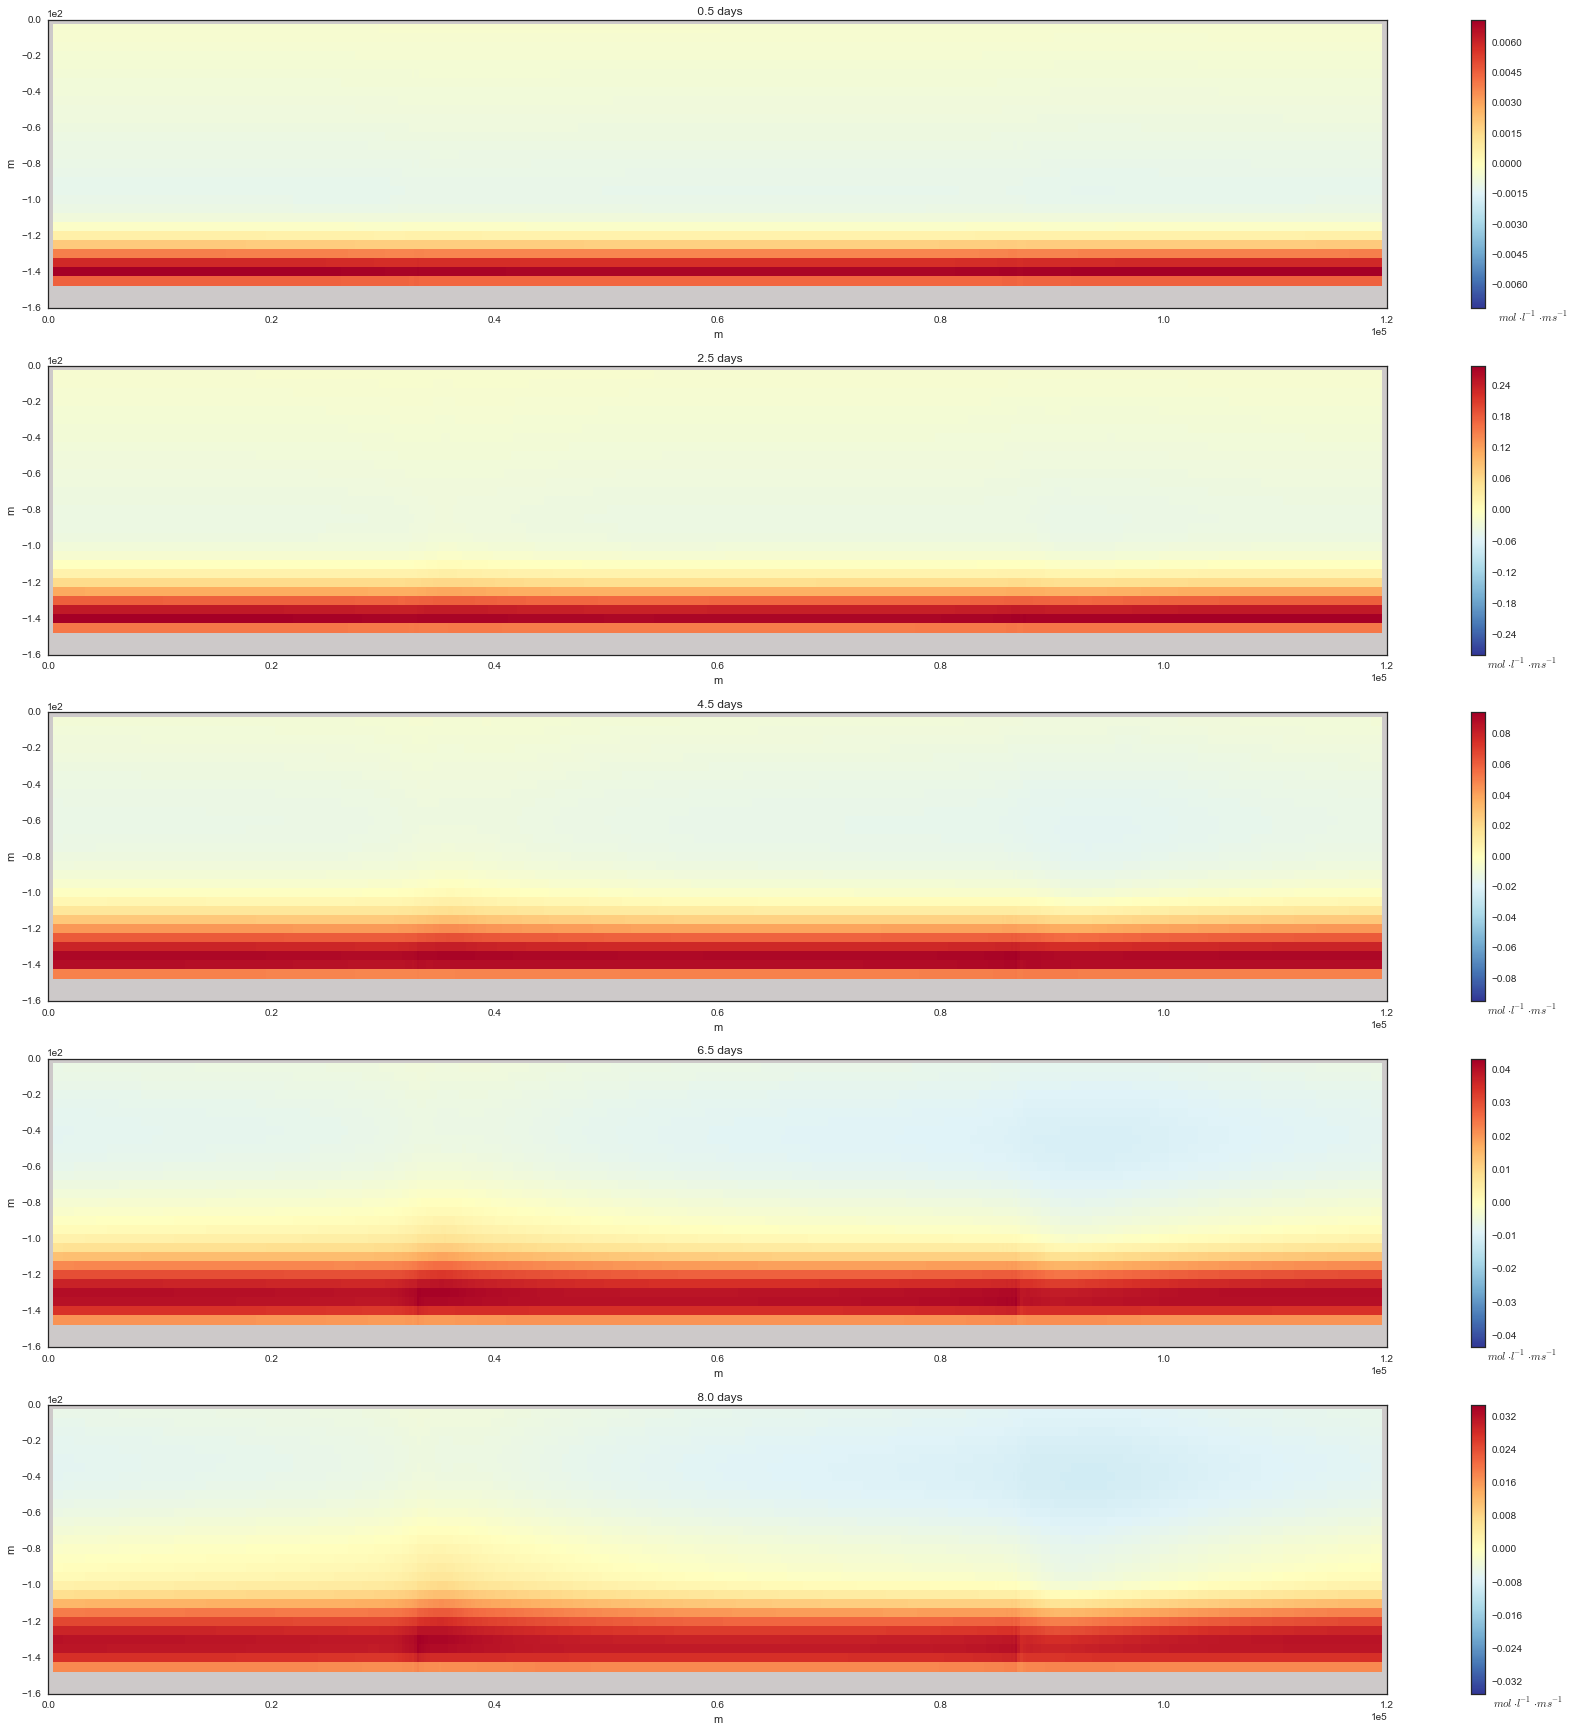

In [99]:
CanyonGridNoC='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')


FluxTR01NoC = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/FluxTR01Glob.nc'

VTRAC01NoC = rout.getField(FluxTR01NoC,'VTRAC01') # 
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
pcolorFluxSB(times,figSize,numCols,numRows,VTRAC01NoC,z,xc,unitsTr,zlev,hFacCNoC,MaskCNoC )

In [130]:

ADVyTr01NoC = rout.getField(FluxTR01NoC,'ADVyTr01') # 